# Experiments with the baseline model


Data from KDD CUP 2009 provided by telecomunication corporation Orange S.A. Data contains 50000 examples and 230 features, the first 190 features are numerical and the last 40 are categorical. The task is to estimate the churn probability of customers (classification problem on unbalanced data). The performance metric is AUC ROC. 

The public data was used in Kaggle competition https://www.kaggle.com/c/telecom-clients-churn-prediction/data. The 50000 examples are splitted into train data (40000 examples) and test data (10000 examples). Competitors don't have access to the test labels so the test data is not supposed to be used in model fitting, but in performance evaluation. 

Previosly several baseline models (logistic regression, random forest, gradient boosting and naive bayes, see "Baseline.ipynb") were tested on a simply preprocessed data. The best result (AUC ROC = 0.727723) was showed by gradient boosting classifier. We will try to improve the result by using various preprocessing techniques and optimizing model parameters. 

### Data preprocessing

This preprocessing has the best AUC ROC achieved on the baseline gradient boosting.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, learning_curve, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv("orange_small_churn_train_data.csv")
data_test = pd.read_csv("orange_small_churn_test_data.csv")
data.drop("ID", axis = 1, inplace = True)
data_test.drop("ID", axis = 1, inplace = True)
print data.shape, data_test.shape
num_features = list(data.columns[:190])
cat_features = list(data.columns[190:230])

(40000, 231) (10000, 230)


In [4]:
def process_data(data, num_features, cat_features, data_test=None):
    delete_empty_features(data, data_test = data_test)
    process_num_features(data, num_features, data_test = data_test)
    process_cat_features(data, cat_features, data_test = data_test)
    #return data, data_test
    

def get_empty_features(data):
    empty_features = []
    c = 0.3
    for feat in data.columns:
        nulls = data[feat].isnull().value_counts()
        try:
            not_nulls = nulls[False]
            if not_nulls < c*40000:
                empty_features.append(feat)
        except:    
            empty_features.append(feat)
    print "number of empty features is", len(empty_features)
    return empty_features

def delete_empty_features(data, data_test = None):
    #delete features with >70% of missed values.
    empty_features = get_empty_features(data)
    for feat in empty_features:
        if feat in num_features:
            num_features.remove(feat)
        else:
            cat_features.remove(feat)
        data.drop(feat, axis=1, inplace=True)
        if data_test is not None:
            data_test.drop(feat, axis=1, inplace=True)
    #return data, data_test


def process_cat_features(data, cat_features, data_test = None):
    #code values with their frequencies     
    if data_test is not None:
        data_cat_all = data[cat_features].append(data_test[cat_features])
        for feat in data_cat_all.columns:
            data_cat_all[feat] = data_cat_all[feat].map(data_cat_all.groupby(feat).size())
        data[cat_features] = data_cat_all.loc[:39999,:]
        data_test[cat_features] = data_cat_all.loc[39999:,:]
    else:
        data_cat_all = data[cat_features]
        for feat in data_cat_all.columns:
            data_cat_all[feat] = data_cat_all[feat].map(data_cat_all.groupby(feat).size())
        data[cat_features] = data_cat_all
        
    #fill missing values with zeros
    data.fillna(0., inplace=True)
    if data_test is not None:
        data_test.fillna(0., inplace=True)
    #return data, data_test

def process_num_features(data, cat_features, data_test = None):
    #fill missing values with max+1
    maxs = data.max(axis = 0)
    for i,feat in enumerate(num_features):
        fill_value = maxs[i]+1
        data.fillna({feat: fill_value}, inplace=True)
        if data_test is not None:
            data_test.fillna({feat: fill_value}, inplace=True)
    #return data, data_test

def scale(data, labels = False, data_test = None):
    scaler = StandardScaler()
    if labels:
        df = data.drop(labels = ['labels'], axis = 1)
        data_scaled = scaler.fit_transform(df)
        data_scaled = pd.DataFrame(data_scaled, index = df.index, columns = df.columns)
        data_scaled['labels'] = data['labels']     
    else: 
        data_scaled = scaler.fit_transform(data)
        data_scaled = pd.DataFrame(data_scaled, index = data.index, columns = data.columns)
        
    if data_test is not None:
        data_test_scaled = scaler.transform(data_test)
        data_test_scaled = pd.DataFrame(data_test_scaled, index = data_test.index, columns = data_test.columns)
    else:
        data_test_scaled = None
    return data_scaled, data_test_scaled

In [5]:
process_data(data, num_features, cat_features, data_test=data_test)
print data.shape
print data_test.shape
data.head()

number of empty features is 156
(40000, 75)
(10000, 74)


,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229,labels
0,3052.0,36.0,97365.0,480.0,600.0,20.0,480.0,200.00,0.0,82752.0,...,3,1662,3,36608.0,0.0,2614,2342,1477,0.0,-1
1,1813.0,7.0,636.0,212.0,265.0,2.0,128.0,166.56,0.0,2706120.0,...,1,37009,1,36608.0,11072.0,2108,35156,4354,9804.0,-1
2,1953.0,7.0,448.0,176.0,220.0,0.0,72.0,311.76,0.0,4698780.0,...,4441,6199,4441,36608.0,0.0,8031,6153,2672,9804.0,-1
3,1533.0,7.0,4.0,332.0,415.0,0.0,144.0,220.08,5.0,864384.0,...,34,37009,34,36608.0,0.0,2108,35156,32703,0.0,1
4,686.0,7.0,0.0,160.0,200.0,2.0,48.0,278.00,0.0,4364880.0,...,2,37009,2,36608.0,0.0,4176,35156,32703,0.0,-1


## Model construction

### Sample size

Lets estimate how many samples are needed to provide a valuable model. It is possible that at some point increase in sample size does not affect the quality of the model. Learning curves are used for better visiability.

In [6]:
clf = GradientBoostingClassifier(random_state = 123)
X = data.drop("labels", axis = 1)
y = data['labels']

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5), random_state = 1):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( 
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, random_state = random_state)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

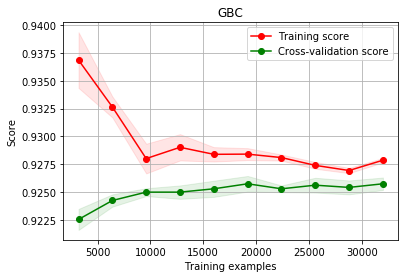

In [19]:
train_sizes = np.arange(0.1,1.1,0.1)
plot_learning_curve(clf, 'GBC', X,y, cv = 5, train_sizes = train_sizes, random_state = 123)
plt.show()

AUC ROC increases with the sample size. We should use at least 80% of the train sample for better results. We will use 32000 examples (80%) as a train set and remaining 8000 examples as a hold-out dataset to test the model performance and control overfitting before submitting its results on the test data (10000 examples).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
best_roc_auc = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
best_roc_auc = np.mean(best_roc_auc)

0.74219734799509662

### Weighting data

Data is unbalanced: only 7% of samples belong to churn class. Lets investigate if weighting can improve the model.

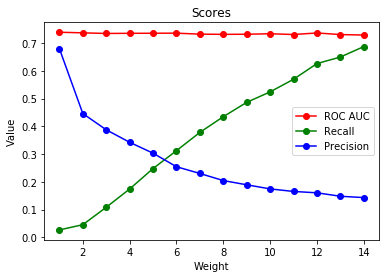

ROC AUC scores [0.73932605878047364, 0.73718224113055419, 0.73494311900629195, 0.73546740021973345, 0.73571024540155916, 0.73604860826684226, 0.73242789107828588, 0.73174306340135487, 0.73212513413518443, 0.73389285090649059, 0.7310819019361734, 0.73672789250678705, 0.73090834971667695, 0.72924361294784834]


In [58]:
weights_sequence = range(1, 15, 1)
precision, recall, roc_auc = [], [], []
for weight in weights_sequence:
    sw = [1 if i == -1 else weight for i in y_train]
    clf = GradientBoostingClassifier(random_state = 123)
    clf.fit(X_train, y_train, sample_weight = sw)
    pred = clf.predict(X_test)
    values = clf.predict_proba(X_test)[:,1]
    
    roc_auc.append(metrics.roc_auc_score(y_test, values))
    recall.append(metrics.recall_score(y_test, pred))
    precision.append(metrics.precision_score(y_test, pred))

    
plt.figure()
plt.title("Scores")
plt.xlabel("Weight")
plt.ylabel("Value")
plt.plot(weights_sequence, roc_auc, 'o-', color="r", label="ROC AUC")
plt.plot(weights_sequence, recall, 'o-', color="g", label="Recall")
plt.plot(weights_sequence, precision, 'o-', color="b", label="Precision")
plt.legend(loc="best")
plt.show()
print "ROC AUC scores", roc_auc

As expected Recall increases with the churn class weight, but at the same time Precision decreases making ROC AUC almost the same. Since the main metric is ROC AUC, for the reason of simplicity we can fit model without weighting.   However from the business perspective it might be better to find maximum possible number of churn users (max Recall) while having Precision on an adequate level. This seems to be achieved for weights [12,1].  

### Numeric features processing

#### Missing values

There were several approaches to deal with missed values in numeric features. Missed values in numeric features were filled with:
- zeros
- means
- medians
- mins - 1 (so that trees could sort missed values more effective)
- maxs + 1 (same)

There were not any large differences, but the best approach is to fill with maxs + 1 (1.0% AUC ROC improvement).

In [164]:
data3 = pd.read_csv("orange_small_churn_train_data.csv")
data3.drop("ID", axis = 1, inplace = True)
for feat in empty_features:
    data3.drop(feat,axis=1, inplace=True)
    
mins = data3.min(axis = 0)
maxs = data3.max(axis = 0)
data30 = data3.fillna(0)

for i, feat in enumerate(num_features):
    m1 = np.mean(data3[feat].dropna())
    m2 = np.median(data3[feat].dropna())
    m3 = mins[i]-1
    m4 = maxs[i]+1
    m_list = [m1, m2, m3, m4]
    #print feat, m_list
    if i == 0:
        data31 = data3.fillna({feat: m1})
        data32 = data3.fillna({feat: m2})
        data33 = data3.fillna({feat: m3})
        data34 = data3.fillna({feat: m4})
        data_list = [data31, data32, data33, data34]
    else: 
        for d, m in zip(data_list, m_list):
            d = d.fillna({feat:m}, inplace = True)
            
data_list = [data30, data31, data32, data33, data34]
descr_list = ['zeros', 'means', 'meds', 'min - 1', 'max + 1']
roc_auc_list = []
for d, descr in zip(data_list, descr_list):
    X = d[num_features].join(data[cat_features])
    y = d['labels']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123)
    ra = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
    roc_auc_list.append(ra)
    print 'for %s filling roc_auc is %f'%(descr, np.mean(ra))

for zeros filling roc_auc is 0.739654
for means filling roc_auc is 0.742015
for meds filling roc_auc is 0.735495
for min - 1 filling roc_auc is 0.737458
for max + 1 filling roc_auc is 0.742197


#### Scaling

The baseline model is GradientBoostingClassifier which does not require data scaling. However many other models, such as regressions, should be used along with data scaling (normalization, taking logarithm etc), otherwise they fail to find the optimum and provide adequate results. Scaling here uses sklearn.preprocessing.StandardScaler.

In [14]:
data_scaled, data_test_scaled = scale(data, labels = True, data_test = data_test)
X_scaled = data_scaled.drop("labels", axis = 1)
y = data_scaled['labels']
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X, y, test_size=0.2, random_state=123)
ra_scaled = cross_val_score(clf, X_train_scaled, y_train_scaled, cv=5, scoring='roc_auc')

print 'ROC AUC with scaling is' , np.mean(ra_scaled)
print 'ROC AUC without scaling is', best_roc_auc

ROC AUC with scaling is 0.742197347995
ROC AUC without scaling is 0.742197347995


### Categorical features processing

Data contains 40 categorical features that are very differenct: from just 2 values to over 17000 values. All values are anonymized. There were several approaches of processing categorical features:

- hashing (parameter: hashing space)
- OneHotEncoding (for features with <400 values)
- replace value with its frequency in traing set 

Best result was showed by the last option with overall AUC ROC improvement by 0.5% compared to hashing with hash space of 400. 

In [62]:
data4 = pd.read_csv("orange_small_churn_train_data.csv")
data4.drop("ID", axis = 1, inplace = True)
print data4.shape
for feat in empty_features:
    data4.drop(feat,axis=1, inplace=True)

data4[num_features] = data[num_features]
data4.fillna(0,inplace = True)

In [167]:
from sklearn.feature_extraction import FeatureHasher
hash_space = 400

cat_x_hashed = pd.DataFrame()
data_set = [data4]
hash_set = [cat_x_hashed]

for feat in cat_features:
    for d, h in zip(data_set, hash_set):
        feat_hashed = [hash(x) % hash_space for x in d[feat]]
        h[str(feat)] = pd.Series(feat_hashed)
data4[cat_features] = cat_x_hashed

clf = GradientBoostingClassifier(random_state = 123)
X = data4.drop("labels", axis = 1)
y = data4['labels']
X_train_hash, X_test_hash, y_train_hash, y_test_hash = train_test_split(
        X, y, test_size=0.2, random_state=123)
ra_hashed = cross_val_score(clf, X_train_hash, y_train_hash, cv=5, scoring='roc_auc')
print 'ROC AUC for hashed categorical features is', np.mean(ra_hashed)
print 'ROC AUC for frequency coding of categorical features is', best_roc_auc

ROC AUC for hashed categorical features is 0.738531609236
ROC AUC for frequency coding of categorical features is 0.742197


### Feature selection

Some features are already excluded from data analysis (fatures that contain more than 70% of missed values). It allows to speed up fit and predict methods while keeping performance on the same level as with these features. The question is if further feature selection can improve model quality. We tried several strategies for feature selection:
- VarianceThreshold (selects features with variance above certain threshold)
- Lasso regression (selects fetures with non-null coefficient in fitted regression with l1 regularization)
- SVM
- Extremely Randomized Trees

##### Feature selection using VarianceThreshold:

In [172]:
from sklearn.feature_selection import VarianceThreshold
X = data.drop('labels', axis = 1)
y = data['labels']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123)

#roc_auc without variance selection is 0.742197
thresholds = [250., 500., 1000., 1500.]
for thr in thresholds:
    selector = VarianceThreshold(thr)
    X_sel = selector.fit_transform(X_train)
    roc_auc = cross_val_score(clf, X_sel, y_train, cv=5, scoring='roc_auc')
    print 'ROC AUC without variance selection is', best_roc_auc
    print 'ROC AUC for %d selected features via VarianceThreshold of %d is %f'% (X_sel.shape[1], thr, np.mean(roc_auc))

roc auc for 64 selected features via VarianceThreshold of 500 is 0.741355
roc auc for 62 selected features via VarianceThreshold of 750 is 0.741716
roc auc for 62 selected features via VarianceThreshold of 1000 is 0.741716
roc auc for 62 selected features via VarianceThreshold of 1250 is 0.741716
roc auc for 60 selected features via VarianceThreshold of 1500 is 0.694973


Feature selection for threshold of 500 and 1000 does not improve the metric. For threshold of 1500 ROC AUC deteriorates, which means that some meaningful features are ignored.

##### Feature selection using Lasso regression: 

In [283]:
alphas = [ 0.0025, 0.005, 0.01, 0.015]
threshold = 1e-10
print 'ROC AUC without variance selection is', best_roc_auc
for a in alphas:
    reg = Lasso(alpha = a)
    reg = reg.fit(X_train_scaled, y_train_scaled)
    coefs = pd.DataFrame(reg.coef_, columns = ['coef'])
    coefs['variable'] = X_train_scaled.columns
    selected_features = list(coefs[abs(coefs['coef']) > threshold].variable)
    X_sel = X_train[selected_features]
    roc_auc = cross_val_score(clf, X_sel, y_train, cv=5, scoring='roc_auc')
    print 'ROC AUC for %d selected features via Lasso regression is %f'% (X_sel.shape[1], np.mean(roc_auc))

ROC AUC without variance selection is 0.742197
ROC AUC for 67 selected features via Lasso regression is 0.743655
ROC AUC for 66 selected features via Lasso regression is 0.743151
ROC AUC for 63 selected features via Lasso regression is 0.743160
ROC AUC for 60 selected features via Lasso regression is 0.743474


Feature selection using Lasso with alpha = 0.0025 slightly improves quality of the model, so we will use only selected features for the final model.

In [285]:
reg = Lasso(alpha = 0.0025)
reg = reg.fit(X_train_scaled, y_train_scaled)
coefs = pd.DataFrame(reg.coef_, columns = ['coef'])
coefs['variable'] = X_train_scaled.columns
selected_features = list(coefs[abs(coefs['coef']) > threshold].variable)
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

##### Feature selection using SVM and Extremely Randomized Trees:

In [227]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

print 'ROC AUC without variance selection is', roc_auc_best

lsvc = LinearSVC(C = 0.25, penalty = "l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train)
values = cross_val_score(clf, X_new, y_train, cv = 5, scoring = 'roc_auc')
print "ROC AUC with LinearSVC feature selection is", values.mean()


etclf = ExtraTreesClassifier()
etclf = etclf.fit(X_train, y_train)
model = SelectFromModel(etclf, prefit=True)
X_new = model.transform(X_train)
values = cross_val_score(clf, X_new, y_train, cv = 5, scoring = 'roc_auc')
print "ROC AUC with ExtraTreesClassifier feature selection is", values.mean()

ROC AUC without variance selection is 0.742197
ROC AUC with LinearSVC feature selection 0.73787893127
ROC AUC with ExtraTreesClassifier feature selection 0.742957671248


Feature selection using SVM or Extremely Randomized Trees does not improve quality of the model.

### Model parameters and GridSearch

Baseline model is Gradient Boosting. We will use the sklearn realization of Gradient Boosting Clasifier algorithm with optimal preprocessing:
- no weighting
- coding categorical features with frequencies
- filling missing values in categorical features with zeros
- filling missing values in numerical features with max + 1
- removal of empty and almost emrty features (>70% of missing values).

Parameters of Gradient Boosting model will be optimized via GridSearch using 5-fold cross validation. 

In [219]:
params = {'n_estimators' : [100, 200, 300, 400, 450, 500],
    'max_depth' : [3, 4], 
    'learning_rate' : [0.1, 0.03]
         }
gs3 = GridSearchCV(clf, params, cv = 5, scoring = 'roc_auc')
gs3.fit(X_train, y_train)
print 'best AUC ROC is', gs3.best_score_
print 'best parameters are', gs3.best_params_

0.745247501522
{'n_estimators': 450, 'learning_rate': 0.03, 'max_depth': 3}


In [278]:
#results = pd.DataFrame(gs3.cv_results_)
#results

Model with max depth of 3 and learning rate of 0.03 is in a (local) optimum at 450 estimators, since its performance is lower at 400 and 500 estimators.  

##### Compared to the baseline model AUC ROC on 5-fold cross validation is increased by 2.4% (from 0.7277 to 0.7452).

## Final model

We will use the sklearn realization of Gradient Boosting Clasifier algorithm with optimal preprocessing:
- no weighting
- coding categorical features with frequencies
- filling missing values in categorical features with zeros
- filling missing values in numerical features with max + 1
- removal of empty and almost emrty features (>70% of missing values)
- feature selection using Lasso regeresiion with regularization coefficient of 0.0025.

and following parameters optimized via GridSearch:

- learning_rate=0.03
- loss='deviance'
- max_depth=3
- n_estimators=450
- random_state=123.


In [289]:
clf = GradientBoostingClassifier(n_estimators = 450, learning_rate = 0.03, max_depth = 3, random_state = 123)
clf.fit(X_train_sel, y_train)
y_pred = clf.predict_proba(X_test_sel) 
y_prob = [x[1] for x in y_pred]
roc_auc_ho = roc_auc_score(y_test, y_prob)
print 'AUC ROC on the hold-out data set is', roc_auc_ho

AUC ROC on the hold-out data set is 0.739029271693


Score on the hold-out data set is close to the score on the train set (0.745), which is an evidence that the model is adequate and is not overfitted.